In [1]:
import os
import time

import numpy as np
import pandas as pd

# !pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# !pip install torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
train_data_x = "camelyonpatch_level_2_split_train_x.h5"
train_data_y = "camelyonpatch_level_2_split_train_y.h5"

test_data_x = "camelyonpatch_level_2_split_test_x.h5"
test_data_y = "camelyonpatch_level_2_split_test_y.h5"

valid_data_x = "camelyonpatch_level_2_split_valid_x.h5"
valid_data_y = "camelyonpatch_level_2_split_valid_y.h5"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Check GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 23 22:42:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3D:00.0 Off |                  N/A |
| 28%   29C    P8     9W / 250W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import torch

In [6]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 2023
setup_seed(SEED)

In [7]:
from torchvision.io import read_image
import h5py
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

#Create custom dataset for our data
class CustomImageDataset(Dataset):
    def __init__(self, xs, ys, transform=None, target_transform=None):
        #Load H5 files
        images_file = h5py.File(xs, 'r')
        labels_file = h5py.File(ys, 'r')

        # Convert files into numpy arrays
        self.images = images_file['x'][()]
        self.labels = labels_file['y'][()]

        self.transform = transform
        self.target_transform = target_transform
        
        # Add PIL conversion transform
        self.to_pil = ToPILImage()
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert numpy array to PIL Image object
        image = self.to_pil(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch import Generator
from torchvision.transforms import ToPILImage

In [11]:
# Resize transform to increase image size to 299x299 to use pretrained 
resize_transform = transforms.Resize((224, 224))
# self.transform = transforms.Compose([transforms.ToTensor()])
# Edit original code to account for resize transformation
train_data = CustomImageDataset(xs = train_data_x, ys = train_data_y,transform=transforms.Compose([resize_transform, ToTensor()]))
test_data = CustomImageDataset(xs = test_data_x, ys = test_data_y, transform=transforms.Compose([resize_transform, ToTensor()]))
validation_data = CustomImageDataset(xs = valid_data_x, ys = valid_data_y, transform=transforms.Compose([resize_transform, ToTensor()]))

In [12]:
# Split data into train, test and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32)

Feature batch shape: torch.Size([32, 224, 224, 3])
Labels batch shape: torch.Size([32, 1, 1, 1])


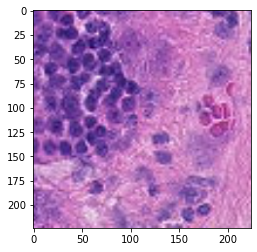

Label: 1


In [13]:
# Display train image and label.
train_features, train_labels = next(iter(train_loader))
train_features = train_features.permute(0, 2, 3, 1)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([32, 224, 224, 3])
Labels batch shape: torch.Size([32, 1, 1, 1])


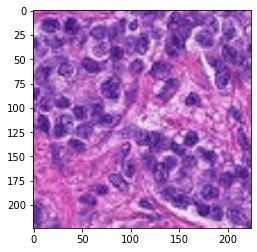

Label: 1


In [14]:
# Display validation image and label.
validation_features, validation_labels = next(iter(validation_loader))
validation_features = validation_features.permute(0, 2, 3, 1)
print(f"Feature batch shape: {validation_features.size()}")
print(f"Labels batch shape: {validation_labels.size()}")
img = validation_features[0].squeeze()
label = validation_labels[0].squeeze()
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [15]:
# from torch import device
# device_cuda = device('cuda')

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    X = X.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 20 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    predicted = []
    labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model()
            test_loss += loss_fn(pred, y).item()
            _, predicted = torch.max(pred.data, 1)
            predicted_labels += predicted.tolist()
            labels = y.squeeze()
            correct += (predicted == labels.to(device)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
#     # Convert predicted labels to numpy array
#     predicted = np.array(predicted)
#     cm = confusion_matrix(labels, predicted)
#     print(cm)
#     report = classification_report(labels, predicted)
#     print(report)
#     tn, fp, fn, tp = cm.ravel()
#     tpr = tp / (tp + fn)
#     fnr = fn / (tp + fn)
#     print(f"True positive rate (TPR): {tpr:.3f}")
#     print(f"False negative rate (FNR): {fnr:.3f}")

In [17]:
# Resnet50 model
from torchvision import models

class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [18]:
import torch.optim as optim

model = ResNet50(num_classes= 2)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
loss_fn = nn.L1Loss()

/home/vwr7bc/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vwr7bc/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train_loop(train_loader, model, loss_fn, optimizer)
    model.eval()
    test_loop(validation_loader, model, loss_fn)

Epoch 1
-------------------------------


/home/vwr7bc/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


loss: 0.778765  [   32/262144]
loss: 0.877979  [  672/262144]
loss: 0.538002  [ 1312/262144]
loss: 0.515678  [ 1952/262144]
loss: 0.516590  [ 2592/262144]
loss: 0.516663  [ 3232/262144]
loss: 0.506248  [ 3872/262144]
loss: 0.518269  [ 4512/262144]
loss: 0.411990  [ 5152/262144]
loss: 0.503202  [ 5792/262144]
loss: 0.533344  [ 6432/262144]
loss: 0.468602  [ 7072/262144]
loss: 0.497171  [ 7712/262144]
loss: 0.497498  [ 8352/262144]
loss: 0.509392  [ 8992/262144]
loss: 0.486018  [ 9632/262144]
loss: 0.480508  [10272/262144]
loss: 0.443897  [10912/262144]
loss: 0.500000  [11552/262144]
loss: 0.477980  [12192/262144]
loss: 0.493617  [12832/262144]
loss: 0.502327  [13472/262144]
loss: 0.511129  [14112/262144]
loss: 0.493245  [14752/262144]
loss: 0.490436  [15392/262144]
loss: 0.495748  [16032/262144]
loss: 0.469971  [16672/262144]
loss: 0.497019  [17312/262144]
loss: 0.515217  [17952/262144]
loss: 0.445421  [18592/262144]
loss: 0.500000  [19232/262144]
loss: 0.540350  [19872/262144]
loss: 0.

TypeError: forward() missing 1 required positional argument: 'x'

In [ ]:
# predicted = list(predicted)
# labels

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# # Convert predicted labels to numpy array
# predicted = np.array(predicted)

# # Calculate confusion matrix
# cm = confusion_matrix(labels, predicted)

# # Print confusion matrix
# print(cm)

# # Calculate classification report
# report = classification_report(labels, predicted)

# # Print classification report
# print(report)

In [ ]:
# # Print True Positive Rate and False Negative Rate
# tn, fp, fn, tp = cm.ravel()

# tpr = tp / (tp + fn)

# fnr = fn / (tp + fn)

# print(f"True positive rate (TPR): {tpr:.3f}")
# print(f"False negative rate (FNR): {fnr:.3f}")